First we will import the libraries

In [ ]:
!pip install opendatasets

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

from math import sqrt
import opendatasets as od

Then we will download and load the dataset

In [ ]:
od.download("https://www.kaggle.com/competitions/rossmann-store-sales/data")

100%|██████████| 6.99M/6.99M [00:00<00:00, 41.7MB/s]


Extracting archive ./rossmann-store-sales/rossmann-store-sales.zip to ./rossmann-store-sales


In [ ]:
train_data = pd.read_csv('/content/rossmann-store-sales/train.csv')
test_data = pd.read_csv('/content/rossmann-store-sales/test.csv')
store_data = pd.read_csv('/content/rossmann-store-sales/store.csv')

In [ ]:
display('Train', train_data.head())
display('Test', test_data.head())
display('Store', store_data.head())

'Train'

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


'Test'

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


'Store'

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
train_data=train_data.merge(store_data, how='left', on='Store')
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
test_data=test_data.merge(store_data, how='left', on='Store')

* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day (this is what you are predicting)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that storefor that store

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

# Data Cleaning

In the **CompetitionDistance** column there are some NAN values. Maybe these NAN values are there because of no existing Competition Store near. There will be a wastage of data if we just remove those rows, So we will fill the NAN values with a very high distance whose importance is not much. Such that even if there is a store in that distance, it poses no competition to the our store

In [ ]:
for index, row in enumerate(train_data.CompetitionDistance):
    if pd.isna(row):
        train_data.loc[index, 'CompetitionDistance'] = (train_data.CompetitionDistance.max())*3

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1017209 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [ ]:
test_data['CompetitionDistance'].fillna(test_data['CompetitionDistance'].max() * 5, inplace=True)

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         41088 non-null  int64  
 1   Store                      41088 non-null  int64  
 2   DayOfWeek                  41088 non-null  int64  
 3   Date                       41088 non-null  object 
 4   Open                       41077 non-null  float64
 5   Promo                      41088 non-null  int64  
 6   StateHoliday               41088 non-null  object 
 7   SchoolHoliday              41088 non-null  int64  
 8   StoreType                  41088 non-null  object 
 9   Assortment                 41088 non-null  object 
 10  CompetitionDistance        41088 non-null  float64
 11  CompetitionOpenSinceMonth  25872 non-null  float64
 12  CompetitionOpenSinceYear   25872 non-null  float64
 13  Promo2                     41088 non-null  int

In [ ]:
sample_data= pd.read_csv('/content/rossmann-store-sales/sample_submission.csv')
sample_data.shape

(41088, 2)

In [ ]:
test_data[test_data['Open'].isna()]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
479,480,622,4,2015-09-17,NaN,1,0,0,a,c,379300.0,NaN,NaN,0,NaN,NaN,NaN
1335,1336,622,3,2015-09-16,NaN,1,0,0,a,c,379300.0,NaN,NaN,0,NaN,NaN,NaN
2191,2192,622,2,2015-09-15,NaN,1,0,0,a,c,379300.0,NaN,NaN,0,NaN,NaN,NaN
3047,3048,622,1,2015-09-14,NaN,1,0,0,a,c,379300.0,NaN,NaN,0,NaN,NaN,NaN
4759,4760,622,6,2015-09-12,NaN,0,0,0,a,c,379300.0,NaN,NaN,0,NaN,NaN,NaN
5615,5616,622,5,2015-09-11,NaN,0,0,0,a,c,379300.0,NaN,NaN,0,NaN,NaN,NaN
6471,6472,622,4,2015-09-10,NaN,0,0,0,a,c,379300.0,NaN,NaN,0,NaN,NaN,NaN
7327,7328,622,3,2015-09-09,NaN,0,0,0,a,c,379300.0,NaN,NaN,0,NaN,NaN,NaN
8183,8184,622,2,2015-09-08,NaN,0,0,0,a,c,379300.0,NaN,NaN,0,NaN,NaN,NaN
9039,9040,622,1,2015-09-07,NaN,0,0,0,a,c,379300.0,NaN,NaN,0,NaN,NaN,NaN


In [ ]:
test_data[['Open', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']] = test_data[['Open', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']].fillna(0)


In [ ]:
test_data[['Promo2SinceWeek',	'Promo2SinceYear', 'PromoInterval']]= test_data[['Promo2SinceWeek',	'Promo2SinceYear', 'PromoInterval']].fillna(0)

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         41088 non-null  int64  
 1   Store                      41088 non-null  int64  
 2   DayOfWeek                  41088 non-null  int64  
 3   Date                       41088 non-null  object 
 4   Open                       41088 non-null  float64
 5   Promo                      41088 non-null  int64  
 6   StateHoliday               41088 non-null  object 
 7   SchoolHoliday              41088 non-null  int64  
 8   StoreType                  41088 non-null  object 
 9   Assortment                 41088 non-null  object 
 10  CompetitionDistance        41088 non-null  float64
 11  CompetitionOpenSinceMonth  41088 non-null  float64
 12  CompetitionOpenSinceYear   41088 non-null  float64
 13  Promo2                     41088 non-null  int

In [ ]:
print(store_data['CompetitionDistance'].max())
print(store_data['CompetitionDistance'].max()*3)

75860.0
227580.0


In [ ]:
max_distance=train_data['CompetitionDistance'].max()*3
(train_data['CompetitionDistance']==max_distance).value_counts()

CompetitionDistance
False    1015202
True        2007
Name: count, dtype: int64

There are some NAN values in **CompetitionOpenSinceMonth	and CompetitionOpenSinceYear**, we  will check if these NAN values are corresponding to the NAN values of **CompetitionDistance** and then if true, we will simply fill them with 0.

In [ ]:
((train_data['CompetitionDistance']==max_distance) & (train_data['CompetitionOpenSinceMonth'].isna()) & (train_data.CompetitionOpenSinceYear.isna())).value_counts()

False    1015202
True        2007
Name: count, dtype: int64

In [ ]:
train_data[['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']] = train_data[['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']].fillna(0)


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1017209 non-null  float64
 12  CompetitionOpenSinceMonth  1017209 non-null  float64
 13  CompetitionO

Some rows in **Promo2SinceWeek	Promo2SinceYear	PromoInterval** are NAN, this could possibly mean that there was no promo2 during that time period

In [ ]:
((train_data['Promo2'] == 0) & (train_data['Promo2SinceWeek'].isna()) & (train_data['Promo2SinceYear'].isna()) & (train_data['PromoInterval'].isna())).value_counts()

False    509178
True     508031
Name: count, dtype: int64

In [ ]:
train_data[['Promo2SinceWeek',	'Promo2SinceYear',	'PromoInterval']] = train_data[['Promo2SinceWeek',	'Promo2SinceYear',	'PromoInterval']].fillna(0)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1017209 non-null  float64
 12  CompetitionOpenSinceMonth  1017209 non-null  float64
 13  CompetitionO

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         41088 non-null  int64  
 1   Store                      41088 non-null  int64  
 2   DayOfWeek                  41088 non-null  int64  
 3   Date                       41088 non-null  object 
 4   Open                       41088 non-null  float64
 5   Promo                      41088 non-null  int64  
 6   StateHoliday               41088 non-null  object 
 7   SchoolHoliday              41088 non-null  int64  
 8   StoreType                  41088 non-null  object 
 9   Assortment                 41088 non-null  object 
 10  CompetitionDistance        41088 non-null  float64
 11  CompetitionOpenSinceMonth  41088 non-null  float64
 12  CompetitionOpenSinceYear   41088 non-null  float64
 13  Promo2                     41088 non-null  int

# Feature Engineering

Lets Start by converting the date to 5 new columns as Year, Month, Day and Week of the Year and Week of the month

In [ ]:
def date_upgrade(df, date):
    df[date] = pd.to_datetime(df[date])
    df['Year'] = df[date].dt.year
    df['Month'] = df[date].dt.month
    df['Day'] = df[date].dt.day
    df['WeekOfYear'] = df[date].dt.isocalendar().week
    df['WeekOfMonth'] = df[date].dt.day // 7 + 1

    return df
date_upgrade(train_data,'Date')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,WeekOfMonth
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,2008.0,0,0.0,0.0,0,2015,7,31,31,5
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,5
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,5
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,2009.0,0,0.0,0.0,0,2015,7,31,31,5
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,2015.0,0,0.0,0.0,0,2015,7,31,31,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,...,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,...,2006.0,0,0.0,0.0,0,2013,1,1,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,...,0.0,0,0.0,0.0,0,2013,1,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,...,0.0,0,0.0,0.0,0,2013,1,1,1,1


In [ ]:
train_data['Date']

0         2015-07-31
1         2015-07-31
2         2015-07-31
3         2015-07-31
4         2015-07-31
             ...    
1017204   2013-01-01
1017205   2013-01-01
1017206   2013-01-01
1017207   2013-01-01
1017208   2013-01-01
Name: Date, Length: 1017209, dtype: datetime64[ns]

In [ ]:
date_upgrade(test_data,'Date')

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,WeekOfMonth
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,...,2008.0,0,0.0,0.0,0,2015,9,17,38,3
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,...,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,9,17,38,3
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,...,2013.0,0,0.0,0.0,0,2015,9,17,38,3
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,...,2014.0,0,0.0,0.0,0,2015,9,17,38,3
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,...,2000.0,0,0.0,0.0,0,2015,9,17,38,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0,a,a,...,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2015,8,1,31,1
41084,41085,1112,6,2015-08-01,1.0,0,0,0,c,c,...,2006.0,0,0.0,0.0,0,2015,8,1,31,1
41085,41086,1113,6,2015-08-01,1.0,0,0,0,a,c,...,0.0,0,0.0,0.0,0,2015,8,1,31,1
41086,41087,1114,6,2015-08-01,1.0,0,0,0,a,c,...,0.0,0,0.0,0.0,0,2015,8,1,31,1


In [ ]:
train_data.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'WeekOfMonth'],
      dtype='object')

Lets add a new column which will showcase the Average Purchase Value

In [ ]:
train_data['Average Purchase Value']= train_data['Sales'] / train_data['Customers']

In [ ]:
display(train_data.sample(10))

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,WeekOfMonth,Average Purchase Value
914651,22,2,2013-04-02,3705,504,1,0,0,1,a,...,1,22.0,2012.0,"Jan,Apr,Jul,Oct",2013,4,2,14,1,7.351190
67183,284,1,2015-06-01,7931,545,1,1,0,1,d,...,1,40.0,2014.0,"Jan,Apr,Jul,Oct",2015,6,1,23,1,14.552294
46949,120,5,2015-06-19,8546,732,1,1,0,0,d,...,1,37.0,2009.0,"Jan,Apr,Jul,Oct",2015,6,19,25,3,11.674863
505147,838,6,2014-04-05,6650,685,1,0,0,0,d,...,1,48.0,2011.0,"Mar,Jun,Sept,Dec",2014,4,5,14,1,9.708029
735265,151,2,2013-09-10,7595,677,1,1,0,0,d,...,0,0.0,0.0,0,2013,9,10,37,2,11.218612
648099,1070,4,2013-11-28,6336,816,1,0,0,0,c,...,0,0.0,0.0,0,2013,11,28,48,5,7.764706
677701,567,5,2013-11-01,0,0,0,0,a,1,c,...,1,18.0,2011.0,"Feb,May,Aug,Nov",2013,11,1,44,1,NaN
590410,246,6,2014-01-18,5503,764,1,0,0,0,c,...,0,0.0,0.0,0,2014,1,18,3,3,7.202880
518221,532,1,2014-03-24,9851,1225,1,0,0,0,a,...,0,0.0,0.0,0,2014,3,24,13,4,8.041633
798109,555,2,2013-07-16,6635,564,1,1,0,0,d,...,1,10.0,2013.0,"Mar,Jun,Sept,Dec",2013,7,16,29,3,11.764184


In [ ]:
train_data.drop(['Average Purchase Value'], axis=1, inplace= True)

Now we will add a column which will for how long the competition store is open near our store

In [ ]:
def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)
comp_months(train_data)

In [ ]:
comp_months(test_data)

In [ ]:
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,WeekOfMonth,CompetitionOpen
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,0,0.0,0.0,0,2015,7,31,31,5,82.0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,5,92.0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,5,103.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,0,0.0,0.0,0,2015,7,31,31,5,70.0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,0,0.0,0.0,0,2015,7,31,31,5,3.0


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 24 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1017209 no

Now we will add 2 columns which tells whether the promo2 is open in that month or not and from how many months the promo2 is running

In [ ]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].fillna(0).map(lambda x: 0 if x < 0 else x) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [ ]:
promo_cols(train_data)

In [ ]:
promo_cols(test_data)

In [ ]:
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,WeekOfMonth,CompetitionOpen,Promo2Open,IsPromo2Month
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,0.0,0,2015,7,31,31,5,82.0,0.000000,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,5,92.0,64.131148,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,5,103.0,51.901639,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,0.0,0,2015,7,31,31,5,70.0,0.000000,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,0.0,0,2015,7,31,31,5,3.0,0.000000,0


We will filter the rows by OPEN column where the store is open

In [ ]:
train_data = train_data[train_data['Open'] != 0]
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 844392 entries, 0 to 1017190
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844392 non-null  int64         
 1   DayOfWeek                  844392 non-null  int64         
 2   Date                       844392 non-null  datetime64[ns]
 3   Sales                      844392 non-null  int64         
 4   Customers                  844392 non-null  int64         
 5   Open                       844392 non-null  int64         
 6   Promo                      844392 non-null  int64         
 7   StateHoliday               844392 non-null  object        
 8   SchoolHoliday              844392 non-null  int64         
 9   StoreType                  844392 non-null  object        
 10  Assortment                 844392 non-null  object        
 11  CompetitionDistance        844392 non-null  float64     

In [ ]:
train_data.reset_index(drop=True, inplace=True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844392 entries, 0 to 844391
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844392 non-null  int64         
 1   DayOfWeek                  844392 non-null  int64         
 2   Date                       844392 non-null  datetime64[ns]
 3   Sales                      844392 non-null  int64         
 4   Customers                  844392 non-null  int64         
 5   Open                       844392 non-null  int64         
 6   Promo                      844392 non-null  int64         
 7   StateHoliday               844392 non-null  object        
 8   SchoolHoliday              844392 non-null  int64         
 9   StoreType                  844392 non-null  object        
 10  Assortment                 844392 non-null  object        
 11  CompetitionDistance        844392 non-null  float64 

In [ ]:
target_train = train_data['Sales'].copy()

# Data Analysis and Visualization

In [ ]:
train_data.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'WeekOfMonth', 'CompetitionOpen', 'Promo2Open',
       'IsPromo2Month'],
      dtype='object')

<Axes: xlabel='Store', ylabel='Sales'>

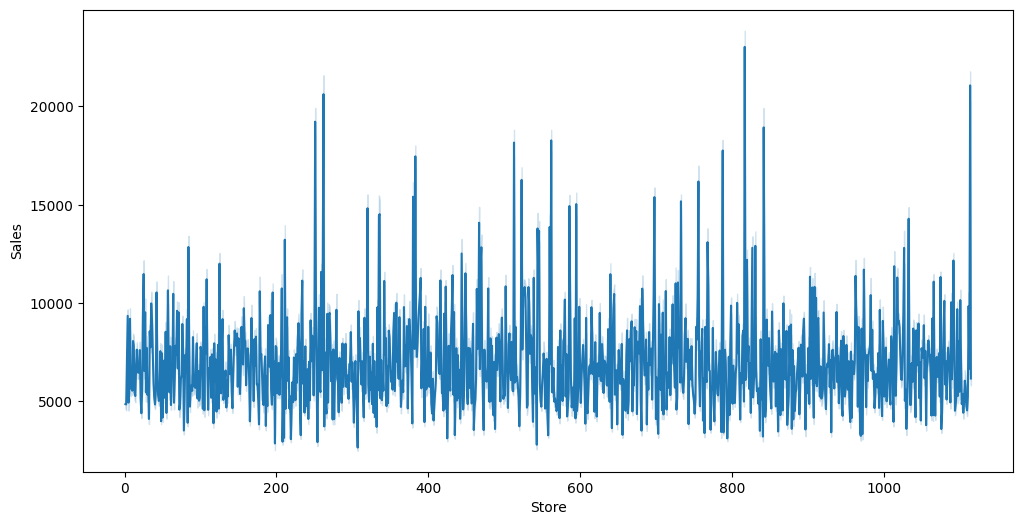

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(data=train_data.sample(100000), x='Store', y='Sales')

<Axes: xlabel='DayOfWeek', ylabel='Sales'>

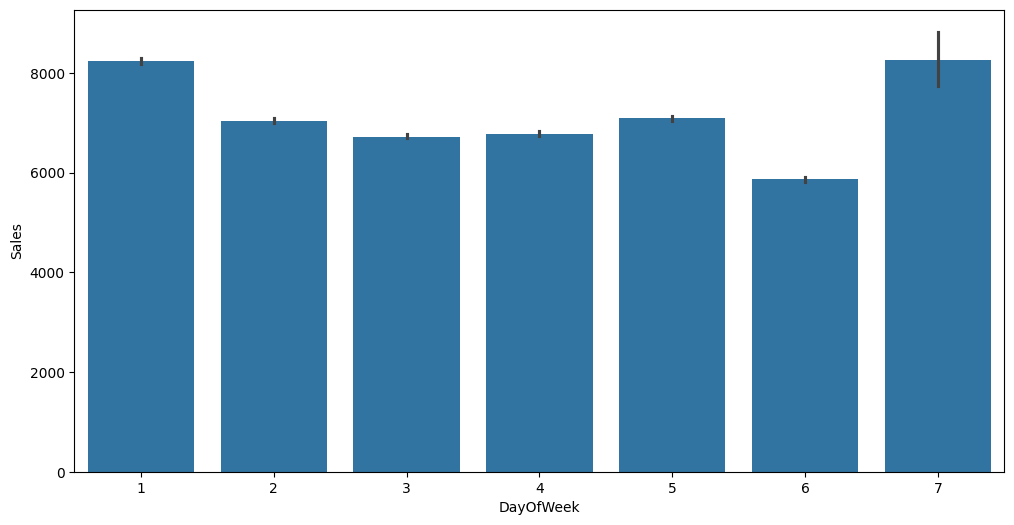

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(data=train_data.sample(100000), x='DayOfWeek', y='Sales')

<Axes: xlabel='Promo', ylabel='Sales'>

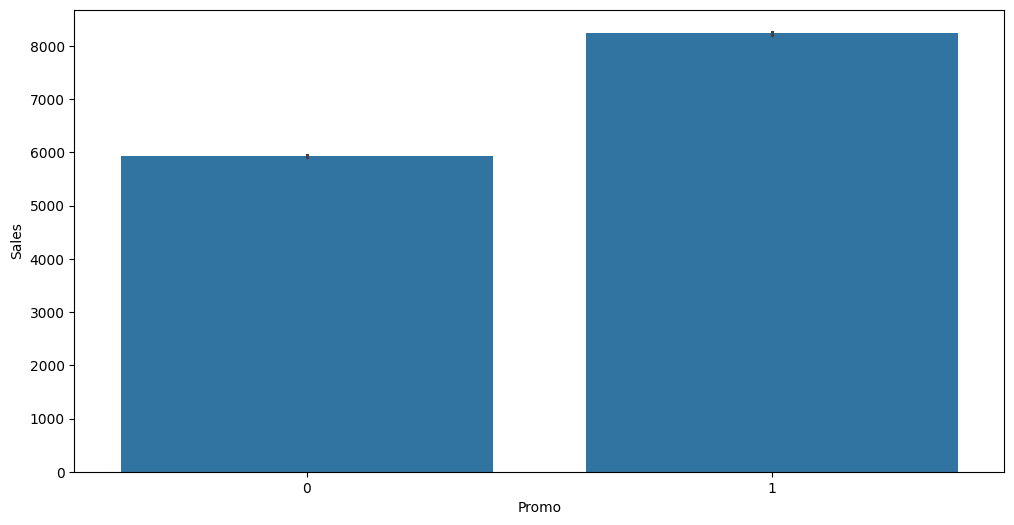

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(data=train_data.sample(100000), x='Promo', y='Sales')

<Axes: xlabel='Month', ylabel='Sales'>

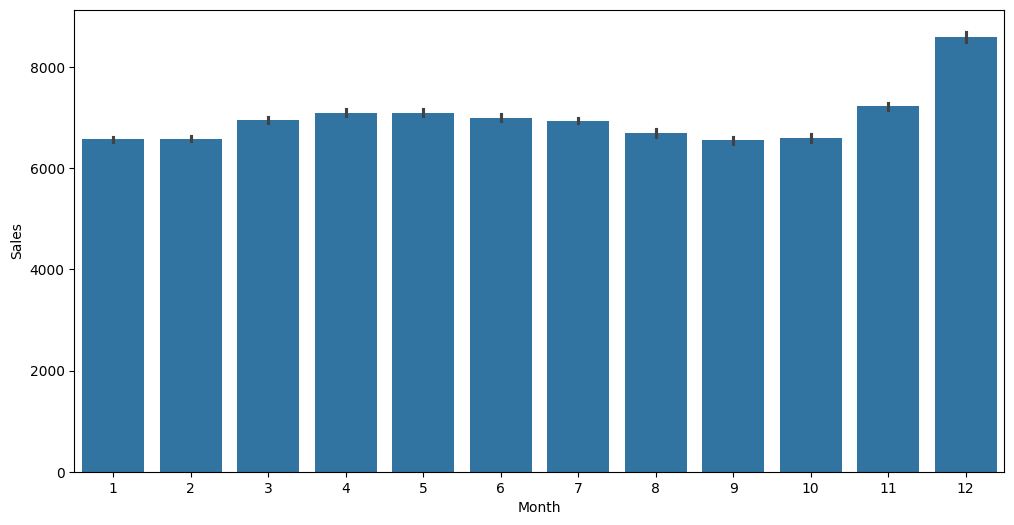

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(data=train_data.sample(100000), x='Month', y='Sales')

<Axes: xlabel='StateHoliday', ylabel='Sales'>

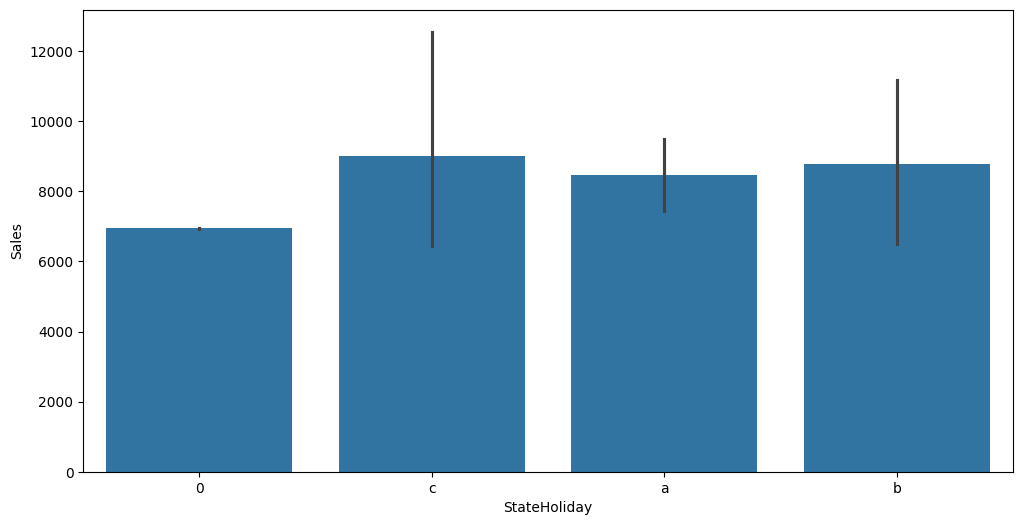

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(data=train_data.sample(100000), x='StateHoliday', y='Sales')

<Axes: xlabel='WeekOfMonth', ylabel='Sales'>

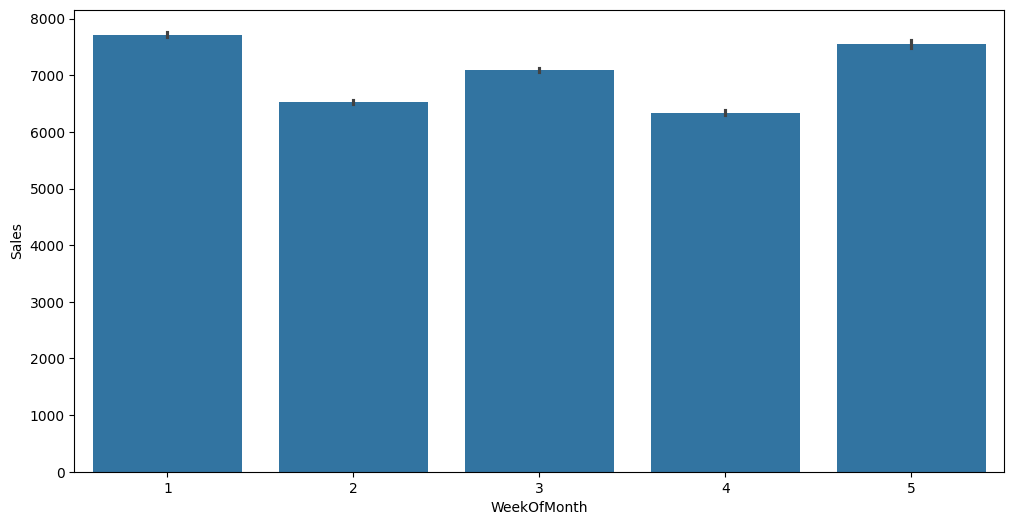

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(data=train_data.sample(100000), x='WeekOfMonth', y='Sales')

<Axes: xlabel='WeekOfYear', ylabel='Sales'>

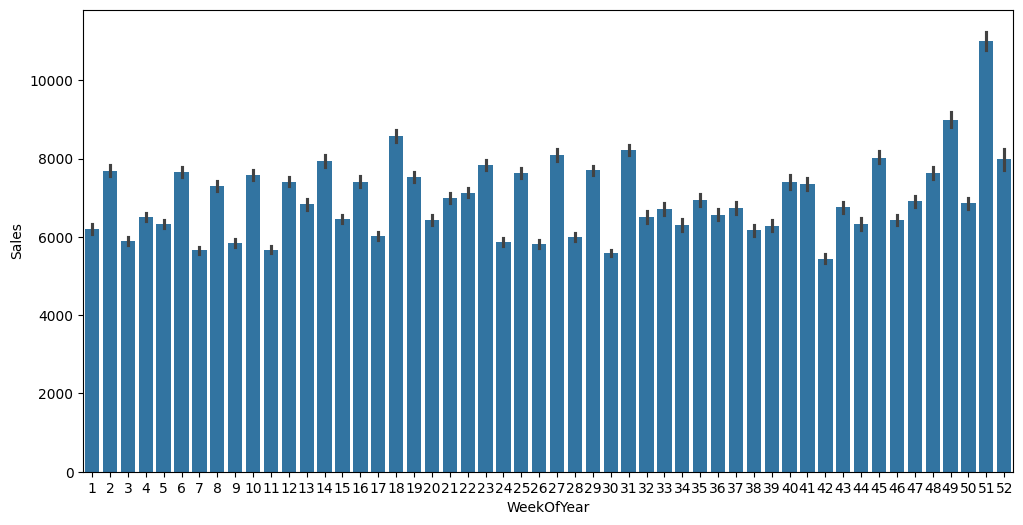

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(data=train_data.sample(100000), x='WeekOfYear', y='Sales')

<Axes: xlabel='Year', ylabel='Sales'>

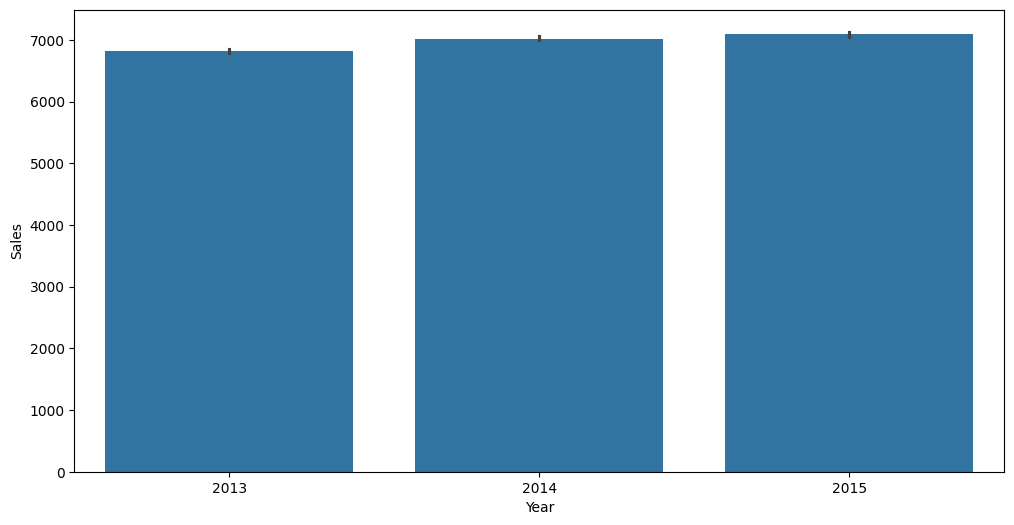

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(data=train_data.sample(100000), x='Year', y='Sales')

<Axes: xlabel='Assortment', ylabel='Sales'>

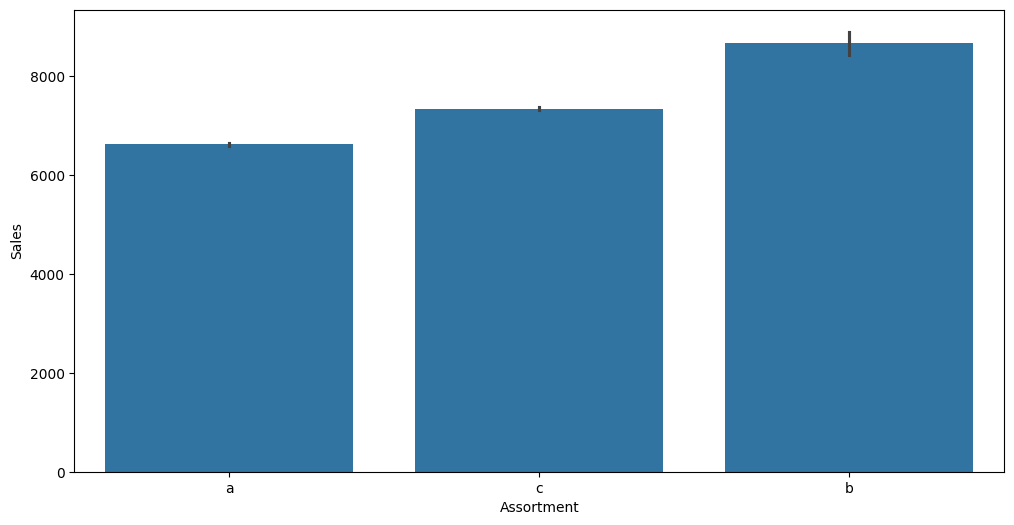

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(data=train_data.sample(100000), x='Assortment', y='Sales')

<Axes: xlabel='Promo2', ylabel='Sales'>

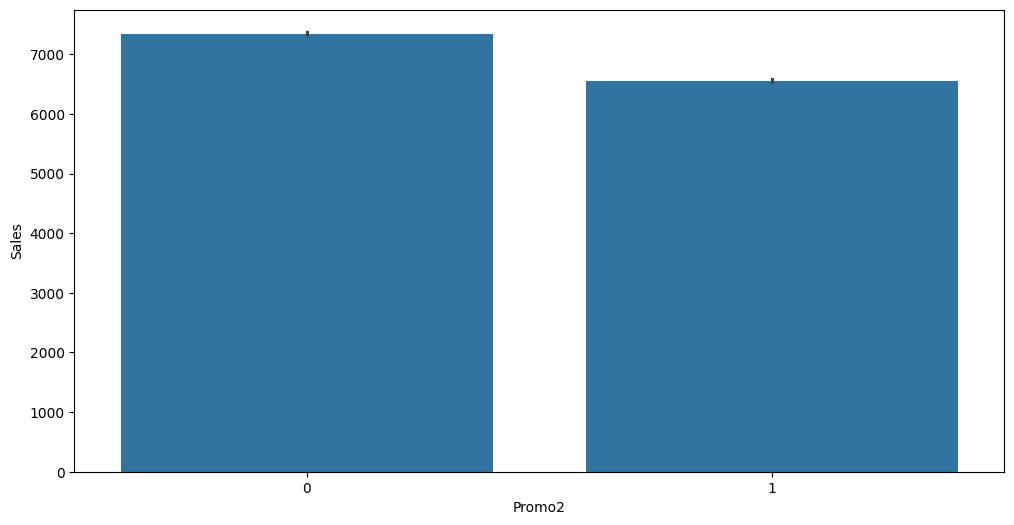

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(data=train_data.sample(100000), x='Promo2', y='Sales')

<Axes: xlabel='Day', ylabel='Sales'>

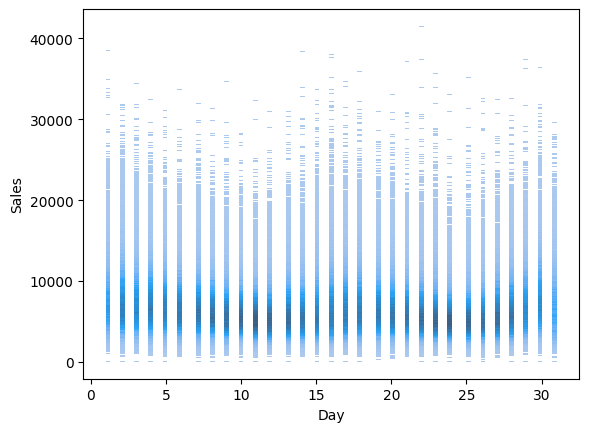

In [ ]:
sns.histplot(data=train_data, x='Day', y='Sales' )

* Weekends have highest sales
* Little more sales with promo
* December has highest sales probably due to Christmas
* Easter holidays have higher sales
* First and last week has highest sales probably because of salary
* Very little effect on sales due to promo 2 compared to promo 1
* B type stores have highest sales

# Feature Encoding

In [ ]:
from sklearn.preprocessing            import LabelEncoder, OneHotEncoder
from sklearn.preprocessing            import StandardScaler, MinMaxScaler, Normalizer, RobustScaler, MaxAbsScaler

In [ ]:
train_data.drop(['Date','Sales', 'Customers', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2SinceWeek',
       'Promo2SinceYear'], axis=1, inplace=True)

In [ ]:
test_data.drop(['Id', 'Date', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2SinceWeek',
       'Promo2SinceYear'], axis=1, inplace=True)

In [ ]:
train_data.head()

,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,PromoInterval,Year,Month,Day,WeekOfYear,WeekOfMonth,CompetitionOpen,Promo2Open,IsPromo2Month
0,1,5,1,1,0,1,c,a,1270.0,0,0,2015,7,31,31,5,82.0,0.000000,0
1,2,5,1,1,0,1,a,a,570.0,1,"Jan,Apr,Jul,Oct",2015,7,31,31,5,92.0,64.131148,1
2,3,5,1,1,0,1,a,a,14130.0,1,"Jan,Apr,Jul,Oct",2015,7,31,31,5,103.0,51.901639,1
3,4,5,1,1,0,1,c,c,620.0,0,0,2015,7,31,31,5,70.0,0.000000,0
4,5,5,1,1,0,1,a,a,29910.0,0,0,2015,7,31,31,5,3.0,0.000000,0


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Store                41088 non-null  int64  
 1   DayOfWeek            41088 non-null  int64  
 2   Open                 41088 non-null  float64
 3   Promo                41088 non-null  int64  
 4   StateHoliday         41088 non-null  object 
 5   SchoolHoliday        41088 non-null  int64  
 6   StoreType            41088 non-null  object 
 7   Assortment           41088 non-null  object 
 8   CompetitionDistance  41088 non-null  float64
 9   Promo2               41088 non-null  int64  
 10  PromoInterval        41088 non-null  object 
 11  Year                 41088 non-null  int32  
 12  Month                41088 non-null  int32  
 13  Day                  41088 non-null  int32  
 14  WeekOfYear           41088 non-null  UInt32 
 15  WeekOfMonth          41088 non-null 

In [ ]:
def data_encoding(encoding_strategy, encoding_data, encoding_columns):
    if encoding_strategy == "LabelEncoding":
        print("IF LabelEncoding")
        Encoder = LabelEncoder()
        for column in encoding_columns:
            print("Column:", column)
            encoding_data[column] = Encoder.fit_transform(encoding_data[column].astype(str))

    elif encoding_strategy == "OneHotEncoding":
        print("ELIF OneHotEncoding")
        for column in encoding_columns:
            encoding_data[column] = encoding_data[column].astype(str)
        Encoder = OneHotEncoder(sparse_output=False, drop='if_binary')
        encoded_data = Encoder.fit_transform(encoding_data[encoding_columns])
        encoded_columns = Encoder.get_feature_names_out(encoding_columns)
        encoded_df = pd.DataFrame(encoded_data, columns=encoded_columns, index=encoding_data.index)
        encoding_data = pd.concat([encoding_data.drop(columns=encoding_columns), encoded_df], axis=1)

    dtypes_list = ['float64', 'float32', 'int64', 'int32']
    for dtype in dtypes_list:
        try:
            encoding_data = encoding_data.astype(dtype)
            break
        except ValueError:
            continue

    return encoding_data

In [ ]:
encoding_columns=['StoreType', 'StateHoliday',	'Assortment', 'PromoInterval', 'DayOfWeek', 'WeekOfMonth']
encoding_strategy = [ "LabelEncoding", "OneHotEncoding"]

In [ ]:
test_data=data_encoding( encoding_strategy[1] , test_data , encoding_columns )

ELIF OneHotEncoding


In [ ]:
display(test_data.head())

,Store,Open,Promo,SchoolHoliday,CompetitionDistance,Promo2,Year,Month,Day,WeekOfYear,...,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,WeekOfMonth_1,WeekOfMonth_2,WeekOfMonth_3,WeekOfMonth_4,WeekOfMonth_5
0,1.0,1.0,1.0,0.0,1270.0,0.0,2015.0,9.0,17.0,38.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3.0,1.0,1.0,0.0,14130.0,1.0,2015.0,9.0,17.0,38.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,7.0,1.0,1.0,0.0,24000.0,0.0,2015.0,9.0,17.0,38.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,8.0,1.0,1.0,0.0,7520.0,0.0,2015.0,9.0,17.0,38.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,9.0,1.0,1.0,0.0,2030.0,0.0,2015.0,9.0,17.0,38.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
train_data = data_encoding( encoding_strategy[1] , train_data , encoding_columns )
display(train_data.head())

ELIF OneHotEncoding


,Store,Open,Promo,SchoolHoliday,CompetitionDistance,Promo2,Year,Month,Day,WeekOfYear,...,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,WeekOfMonth_1,WeekOfMonth_2,WeekOfMonth_3,WeekOfMonth_4,WeekOfMonth_5
0,1.0,1.0,1.0,1.0,1270.0,0.0,2015.0,7.0,31.0,31.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2.0,1.0,1.0,1.0,570.0,1.0,2015.0,7.0,31.0,31.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3.0,1.0,1.0,1.0,14130.0,1.0,2015.0,7.0,31.0,31.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4.0,1.0,1.0,1.0,620.0,0.0,2015.0,7.0,31.0,31.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5.0,1.0,1.0,1.0,29910.0,0.0,2015.0,7.0,31.0,31.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
test_data.shape

(41088, 37)

In [ ]:
test_data[['StateHoliday_0', 'StateHoliday_b', 'StateHoliday_c']]=0.0

In [ ]:
train_data.shape

(844392, 40)

# Feature Scaling

In [ ]:
input_cols=['Store', 'Open', 'Promo', 'SchoolHoliday', 'CompetitionDistance',
       'Promo2', 'Year', 'Month', 'Day', 'WeekOfYear',
       'Average Purchase Value', 'CompetitionOpen', 'Promo2Open',
       'IsPromo2Month', 'StoreType_a', 'StoreType_b', 'StoreType_c',
       'StoreType_d', 'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b',
       'StateHoliday_c', 'Assortment_a', 'Assortment_b', 'Assortment_c',
       'PromoInterval_0', 'PromoInterval_Feb,May,Aug,Nov',
       'PromoInterval_Jan,Apr,Jul,Oct', 'PromoInterval_Mar,Jun,Sept,Dec',
       'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4',
       'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7', 'WeekOfMonth_1',
       'WeekOfMonth_2', 'WeekOfMonth_3', 'WeekOfMonth_4', 'WeekOfMonth_5']
target_col= 'Sales'

In [ ]:
def data_scaling( scaling_strategy , scaling_data , scaling_columns ):

    if    scaling_strategy =="RobustScaler" :
        scaling_data[scaling_columns] = RobustScaler().fit_transform(scaling_data[scaling_columns])

    elif  scaling_strategy =="StandardScaler" :
        scaling_data[scaling_columns] = StandardScaler().fit_transform(scaling_data[scaling_columns])

    elif  scaling_strategy =="MinMaxScaler" :
        scaling_data[scaling_columns] = MinMaxScaler().fit_transform(scaling_data[scaling_columns])

    elif  scaling_strategy =="MaxAbsScaler" :
        scaling_data[scaling_columns] = MaxAbsScaler().fit_transform(scaling_data[scaling_columns])

    else :  # If any other scaling send by mistake still perform Robust Scalar
        scaling_data[scaling_columns] = RobustScaler().fit_transform(scaling_data[scaling_columns])

    return scaling_data

In [ ]:
inf_check = np.isinf(test_data).sum()
print(f"Number of infinity values in each column:\n{inf_check}")

Number of infinity values in each column:
Store                             0
Open                              0
Promo                             0
SchoolHoliday                     0
CompetitionDistance               0
Promo2                            0
Year                              0
Month                             0
Day                               0
WeekOfYear                        0
CompetitionOpen                   0
Promo2Open                        0
IsPromo2Month                     0
StoreType_a                       0
StoreType_b                       0
StoreType_c                       0
StoreType_d                       0
StateHoliday_a                    0
Assortment_a                      0
Assortment_b                      0
Assortment_c                      0
PromoInterval_0                   0
PromoInterval_Feb,May,Aug,Nov     0
PromoInterval_Jan,Apr,Jul,Oct     0
PromoInterval_Mar,Jun,Sept,Dec    0
DayOfWeek_1                       0
DayOfWeek_2           

In [ ]:
inf_check = np.isinf(train_data).sum()
print(f"Number of infinity values in each column:\n{inf_check}")

Number of infinity values in each column:
Store                                0
Open                                 0
Promo                                0
SchoolHoliday                        0
CompetitionDistance               1660
Promo2                               0
Year                                 0
Month                                0
Day                                  0
WeekOfYear                           0
CompetitionOpen                      0
Promo2Open                           0
IsPromo2Month                        0
StoreType_a                          0
StoreType_b                          0
StoreType_c                          0
StoreType_d                          0
StateHoliday_0                       0
StateHoliday_a                       0
StateHoliday_b                       0
StateHoliday_c                       0
Assortment_a                         0
Assortment_b                         0
Assortment_c                         0
PromoInterval_0       

In [ ]:
train_data.replace([np.inf, -np.inf], 10000, inplace=True)

In [ ]:
scaling_strategy = ["RobustScaler", "StandardScaler","MinMaxScaler","MaxAbsScaler"]
train_data = data_scaling( scaling_strategy[2] , train_data , train_data.columns )

display(train_data.head())

,Store,Open,Promo,SchoolHoliday,CompetitionDistance,Promo2,Year,Month,Day,WeekOfYear,...,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,WeekOfMonth_1,WeekOfMonth_2,WeekOfMonth_3,WeekOfMonth_4,WeekOfMonth_5
0,0.000000,0.0,1.0,1.0,1.581769e-304,0.0,1.0,0.545455,1.0,0.588235,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.000898,0.0,1.0,1.0,6.959782e-305,1.0,1.0,0.545455,1.0,0.588235,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.001795,0.0,1.0,1.0,1.785500e-303,1.0,1.0,0.545455,1.0,0.588235,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.002693,0.0,1.0,1.0,7.592489e-305,0.0,1.0,0.545455,1.0,0.588235,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.003591,0.0,1.0,1.0,3.782325e-303,0.0,1.0,0.545455,1.0,0.588235,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
test_data = data_scaling( scaling_strategy[2] , test_data , test_data.columns )

In [ ]:
test_data.head()

,Store,Open,Promo,SchoolHoliday,CompetitionDistance,Promo2,Year,Month,Day,WeekOfYear,...,DayOfWeek_6,DayOfWeek_7,WeekOfMonth_1,WeekOfMonth_2,WeekOfMonth_3,WeekOfMonth_4,WeekOfMonth_5,StateHoliday_0,StateHoliday_b,StateHoliday_c
0,0.000000,1.0,1.0,0.0,0.003296,0.0,0.0,1.0,0.533333,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.001795,1.0,1.0,0.0,0.037202,1.0,0.0,1.0,0.533333,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.005386,1.0,1.0,0.0,0.063225,0.0,0.0,1.0,0.533333,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.006284,1.0,1.0,0.0,0.019774,0.0,0.0,1.0,0.533333,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.007181,1.0,1.0,0.0,0.005300,0.0,0.0,1.0,0.533333,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# Training the Model

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_data, target_train, test_size=0.1, random_state=42)

In [ ]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=40, max_depth=20, learning_rate=0.1)

In [ ]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=40, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
preds = model.predict(X_train)

In [ ]:
def rmse(x_true, x_pred):
    mse = mean_squared_error(x_true, x_pred)
    rmse = np.sqrt(mse)
    return rmse

In [ ]:
rmse(y_val, model.predict(X_val))

1295.0069510019061

In [ ]:
rmse(y_train, preds)

688.0108616459976

In [ ]:
model= RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=36, max_depth=38)
model.fit(X_train, y_train)
preds= model.predict(X_train)

In [ ]:
rmse(y_train, preds)

388.6736288921865

In [ ]:
rmse(y_val, model.predict(X_val))

1004.5986745050673

In [ ]:
def regressors(model_type, X_train, y_train, X_val, y_val):

    if model_type == 1:
        model = Ridge(alpha=1.0)
    elif model_type == 2:
        model = Lasso(alpha=0.1)
    elif model_type == 3:
        model = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=36, max_depth=38)
    elif model_type == 4:
        model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    elif model_type == 5:
        model = XGBRegressor(learning_rate=0.1,random_state=42, n_jobs=-1, n_estimators=40, max_depth=25)
    else:
        raise ValueError("Invalid model type. Choose from 'ridge', 'lasso', 'random_forest', 'gradient_boosting', or 'xgboost'.")


    model.fit(X_train, y_train)
    pred = model.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train, pred))

    t_pred = model.predict(X_val)
    t_rmse = np.sqrt(mean_squared_error(y_val, t_pred))
    return {'RMSE_train': rmse, 'RMSE_test': t_rmse}

In [ ]:
regressors(5, X_train, y_train, X_val, y_val)

{'RMSE_train': 428.50364342486165, 'RMSE_test': 1257.9861487566166}

In [ ]:
regressors(3, X_train, y_train, X_val, y_val)

KeyboardInterrupt: 

In [ ]:
regressors(4, X_train, y_train, X_val, y_val)

{'RMSE_train': 2460.8775329812775, 'RMSE_test': 2474.783105448567}

In [ ]:
regressors(1, X_train, y_train, X_val, y_val)

{'RMSE_train': 2711.159638659273, 'RMSE_test': 2721.58758374764}

In [ ]:
regressors(2, X_train, y_train, X_val, y_val)

{'RMSE_train': 2711.1682570098797, 'RMSE_test': 2721.6177110278504}

In [ ]:
model = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=36, max_depth=38)

In [ ]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=38, n_estimators=36, n_jobs=-1, random_state=42)

In [ ]:
correct_order = ['Store', 'Open', 'Promo', 'SchoolHoliday', 'CompetitionDistance',
                 'Promo2', 'Year', 'Month', 'Day', 'WeekOfYear', 'CompetitionOpen',
                 'Promo2Open', 'IsPromo2Month', 'StoreType_a', 'StoreType_b',
                 'StoreType_c', 'StoreType_d', 'StateHoliday_0', 'StateHoliday_a',
                 'StateHoliday_b', 'StateHoliday_c', 'Assortment_a', 'Assortment_b',
                 'Assortment_c', 'PromoInterval_0', 'PromoInterval_Feb,May,Aug,Nov',
                 'PromoInterval_Jan,Apr,Jul,Oct', 'PromoInterval_Mar,Jun,Sept,Dec',
                 'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4',
                 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7', 'WeekOfMonth_1',
                 'WeekOfMonth_2', 'WeekOfMonth_3', 'WeekOfMonth_4', 'WeekOfMonth_5']

test_data = test_data[correct_order]


In [ ]:
preds= model.predict(test_data)

In [ ]:

# Multiply by 'Open' column to adjust predicted sales
adjusted_sales = predicted_sales * test_data['Open']

# Assuming 'sample_data' is your sample submission DataFrame with an 'Id' column
sample_data['Sales'] = adjusted_sales

# Save the DataFrame to a new CSV file
sample_data.to_csv('adjusted_submission.csv', index=False)


In [ ]:
sample_data.head()

,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [ ]:
print(preds)

[ 8158.22222222 10852.94444444 13155.77777778 ...  6443.97222222
 26582.11111111  8708.47222222]


In [ ]:
adjusted_sales = preds * test_data['Open']

sample_data['Sales'] = adjusted_sales

# Save the updated DataFrame to a new CSV file
sample_data.to_csv('sample_submission.csv', index=False)


In [ ]:
x=pd.read_csv('/content/sample_submission.csv')

In [ ]:
x.sample(30)

,Id,Sales
35241,35242,6785.710317
28802,28803,6584.083333
14111,14112,8958.444444
20722,20723,8029.500000
9666,9667,0.000000
11129,11130,8529.972222
14032,14033,8381.166667
37703,37704,6998.500000
19350,19351,6178.805556
316,317,13185.083333


In [ ]:
def regressors(model_type, X_train, y_train, X_val, y_val):

    if model_type == 1:
        model = Ridge(alpha=0.12, tol=0.05, max_iter=40)
    elif model_type == 2:
        model = Lasso(alpha=0.1, warm_start=True, tol=0.05, max_iter=40)
    elif model_type == 3:
        model = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=36, max_depth=38)
    elif model_type == 4:
        model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    elif model_type == 5:
        model = XGBRegressor(learning_rate=0.72, random_state=42, n_jobs=-1, n_estimators=120, max_depth=120, max_leaves=140)
    else:
        raise ValueError("Invalid model type. Choose from 'ridge', 'lasso', 'random_forest', 'gradient_boosting', or 'xgboost'.")


    model.fit(X_train, y_train)
    pred = model.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train, pred))

    t_pred = model.predict(X_val)
    t_rmse = np.sqrt(mean_squared_error(y_val, t_pred))
    return {'RMSE_train': rmse, 'RMSE_test': t_rmse}

In [ ]:
regressors(3, X_train, y_train, X_val, y_val)

KeyboardInterrupt: 

In [ ]:
regressors(5, X_train, y_train, X_val, y_val)

{'RMSE_train': 899.1120406011959, 'RMSE_test': 974.7133653094995}

In [ ]:
regressors(1, X_train, y_train, X_val, y_val)

{'RMSE_train': 2711.1594516357427, 'RMSE_test': 2721.5876497800364}

In [ ]:
regressors(2, X_train, y_train, X_val, y_val)

{'RMSE_train': 2711.1849014205695, 'RMSE_test': 2721.6345010230593}

In [ ]:
RandomForestRegressor?

In [ ]:
!pip install lightgbm

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
from sklearn.ensemble import StackingRegressor

def regressors(X_train, y_train, X_val, y_val):
    # Define base models
    base_models = [
        ('random_forest', RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=36, max_depth=38)),
        #('gradient_boosting', GradientBoostingRegressor(n_estimators=70,warm_start=True,tol=0.005, learning_rate=0.1, random_state=42)),
        ('xgboost', XGBRegressor(learning_rate=0.72, random_state=42, n_jobs=-1, n_estimators=120, max_depth=120, max_leaves=140))
    ]

    # Define meta-model
    meta_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)


    # Create the stacking ensemble
    model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=3, n_jobs=-1)

    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions and calculate RMSE
    pred = model.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train, pred))

    t_pred = model.predict(X_val)
    t_rmse = np.sqrt(mean_squared_error(y_val, t_pred))

    return {'RMSE_train': rmse, 'RMSE_test': t_rmse}


In [ ]:
regressors(X_train, y_train, X_val, y_val)

In [ ]:
adjusted_sales = preds * test_data['Open']

sample_data['Sales'] = adjusted_sales

# Save the updated DataFrame to a new CSV file
sample_data.to_csv('sample_submission.csv', index=False)
